# Tutorial on MDN

From https://mikedusenberry.com/mixture-density-networks.

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = [8, 8]
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(0)


In [4]:
# generate the data
n = 2500
d, t = 1, 1
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.normal(-0.1, 0.1, (n, t)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise
x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)


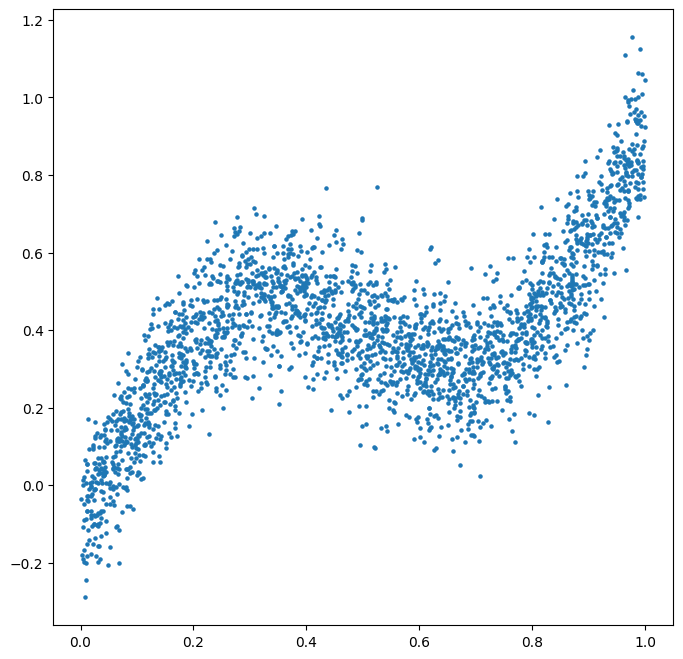

In [5]:
# plot
fig = plt.figure()
plt.scatter(x_train, y_train, s=5)
plt.show()

In [8]:
# define a simple neural network
h = 15
w1 = Variable(torch.randn(d, h)*np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t)*np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    out = out.mm(w2) + b2
    return out

x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

opt = optim.Adam([w1, b1, w2, b2], lr=0.01)

for e in range(2000):
    opt.zero_grad()
    out = forward(x)
    loss = F.mse_loss(out, y)
    if e%100 == 0:
        print(e, loss.item())
    loss.backward()
    opt.step()

0 0.047641534358263016
100 0.02641013264656067
200 0.014945579692721367
300 0.010401024483144283
400 0.010238267481327057
500 0.01018094178289175
600 0.01015020627528429
700 0.010138683021068573
800 0.010109455324709415
900 0.01009688712656498
1000 0.010085398331284523
1100 0.010082574561238289
1200 0.01007063314318657
1300 0.0102858766913414
1400 0.010061047039926052
1500 0.010057387873530388
1600 0.010054762475192547
1700 0.010052269324660301
1800 0.010050327517092228
1900 0.010048758238554


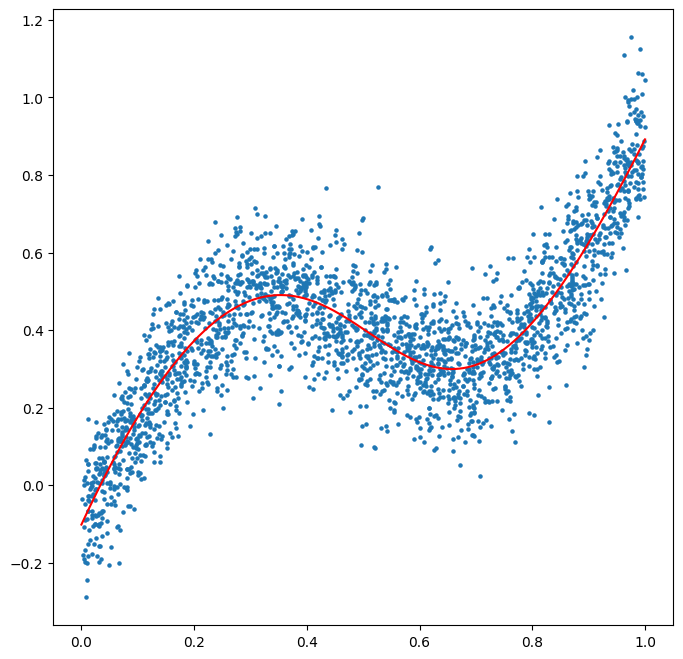

In [15]:
fig = plt.figure()
plt.scatter(x_train, y_train, s=5)
out = forward(Variable(torch.from_numpy(x_test)))
plt.plot(x_test, out.data.numpy(), color='r')
plt.show()

## Invert the problem

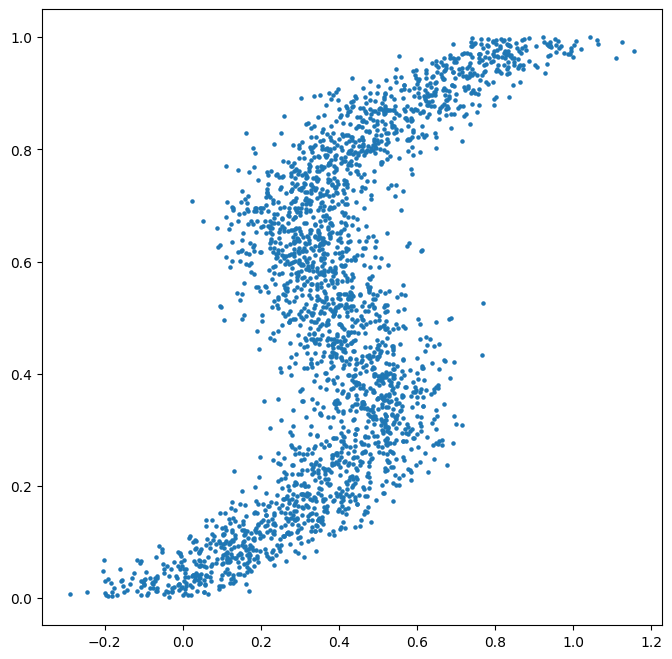

In [16]:
x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)

fig = plt.figure()
plt.scatter(x_train_inv, y_train_inv, s=5)
plt.show()

In [19]:
# define a simple neural network
h = 15
w1 = Variable(torch.randn(d, h)*np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t)*np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    out = out.mm(w2) + b2
    return out

x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

opt = optim.Adam([w1, b1, w2, b2], lr=0.01)

for e in range(2000):
    opt.zero_grad()
    out = forward(x)
    loss = F.mse_loss(out, y)
    if e%100 == 0:
        print(e, loss.item())
    loss.backward()
    opt.step()

0 0.3791223168373108
100 0.05377762392163277
200 0.05340472236275673
300 0.05310550704598427
400 0.05289369449019432
500 0.05275421217083931
600 0.05265933275222778
700 0.05258117616176605
800 0.05250116065144539
900 0.05240897089242935
1000 0.05229733884334564
1100 0.052157897502183914
1200 0.051980774849653244
1300 0.0517624206840992
1400 0.05152309685945511
1500 0.05129622295498848
1600 0.05107036605477333
1700 0.0508016012609005
1800 0.05047066509723663
1900 0.0500778891146183


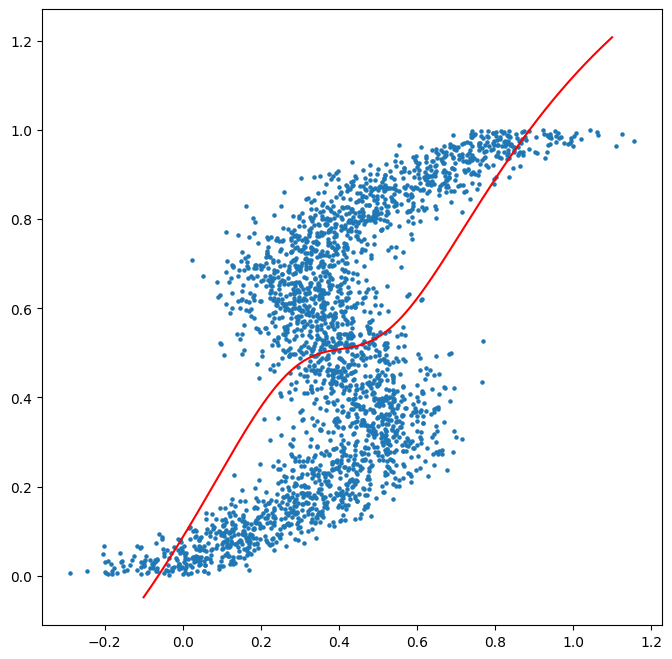

In [21]:
fig = plt.figure()
plt.scatter(x_train_inv, y_train_inv, s=5)
out = forward(Variable(torch.from_numpy(x_test)))
plt.plot(x_test, out.data.numpy(), color='r')
plt.show()

Hmm fails because P(x|y) is multimodal!
Need
## Mixture Density Networks